In [8]:
import argparse
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tabulate import tabulate

from model import BertCustomBinaryClassifier
from utils.ensemble_utils import make_predictions
from utils.evaluate_metrics import evaluate_metrics
from utils.data_preprocessing import load_dataset

In [9]:
import logging
logging.getLogger("transforkmer_values.modeling_utils").setLevel(logging.ERROR)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", type=int, default=64, help="")
parser.add_argument("--max_length", type=int, default=200, help="")
args = parser.parse_args(args=[])

# **BERT Models**

In [12]:
threshold = 0.50
kmer_values = [3, 4, 5, 6]
model_date = "2025-02-27_V2"
test_predictions_list, test_labels_list = [], []
train_predictions_list, train_labels_list = [], []

print(f"Classifier model date: {model_date}")
print(f"Threshold: {threshold}")

# Initialize lists to store results
results = []  #


for kmer in kmer_values:

    args.model_path = f"./outputs/classifier_models/{model_date}/{kmer}-mer"
    args.test_data_path = f"./data/enhancer_classification/{kmer}-mer_classification_test.txt"
    args.train_data_path = f"./data/enhancer_classification/{kmer}-mer_classification_train.txt"

    # Load training and testing datasets
    train_dataset = load_dataset(args, validation=False)
    test_dataset = load_dataset(args, validation=True)

    # Initialize data loaders for batch processing
    train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

    # Model
    model = BertCustomBinaryClassifier.from_pretrained(args.model_path, num_labels=1).to(device)

    # Prediction on training dataset
    train_predictions, train_labels = make_predictions(model, train_dataloader, kmer=kmer)
    train_predictions_list.append(train_predictions)
    train_labels_list.append(train_labels)

    acc, sn, sp, mcc, auc = evaluate_metrics(train_predictions, train_labels, threshold=threshold)
    results.append({"k-mer": kmer, "Dataset": "Train", "Accuracy": acc, "Sensitivity": sn, "Specificity": sp, "MCC": mcc, "AUC": auc})

    # Prediction on test (independent) dataset
    test_predictions, test_labels = make_predictions(model, test_dataloader, kmer=kmer)
    test_predictions_list.append(test_predictions)
    test_labels_list.append(test_labels)

    acc, sn, sp, mcc, auc = evaluate_metrics(test_predictions, test_labels, threshold=threshold)
    results.append({"k-mer": kmer, "Dataset": "Test", "Accuracy": acc, "Sensitivity": sn, "Specificity": sp, "MCC": mcc, "AUC": auc})

Classifier model date: 2025-02-27_V2
Threshold: 0.5


In [13]:
# Convert results to DataFrame for tabulation
results_df = pd.DataFrame(results, columns=["k-mer", "Dataset", "Accuracy", "Sensitivity", "Specificity", "MCC", "AUC"])

# Split DataFrame into training and testing
training_df = results_df[results_df['Dataset'].str.contains("Train")]
testing_df = results_df[results_df['Dataset'].str.contains("Test")]

# Display results in tabulated format
print("Training Results:")
print(tabulate(training_df, headers="keys", tablefmt="grid", showindex=False, floatfmt=".4f"))

print("\nTesting Results:")
print(tabulate(testing_df, headers="keys", tablefmt="grid", showindex=False, floatfmt=".4f"))

Training Results:
+---------+-----------+------------+---------------+---------------+--------+--------+
|   k-mer | Dataset   |   Accuracy |   Sensitivity |   Specificity |    MCC |    AUC |
+=========+===========+============+===============+===============+========+========+
|       3 | Train     |     0.8888 |        0.8302 |        0.9474 | 0.7830 | 0.9162 |
+---------+-----------+------------+---------------+---------------+--------+--------+
|       4 | Train     |     0.9111 |        0.8639 |        0.9582 | 0.8258 | 0.9218 |
+---------+-----------+------------+---------------+---------------+--------+--------+
|       5 | Train     |     0.8982 |        0.8329 |        0.9636 | 0.8034 | 0.8944 |
+---------+-----------+------------+---------------+---------------+--------+--------+
|       6 | Train     |     0.9043 |        0.8423 |        0.9663 | 0.8149 | 0.8987 |
+---------+-----------+------------+---------------+---------------+--------+--------+

Testing Results:
+------

In [14]:
threshold = 0.5
# Calculate averages for training predictions and labels
train_predictions_average = np.array(train_predictions_list).mean(axis=0)
train_labels_average = np.array(train_labels_list).mean(axis=0)
train_acc, train_sn, train_sp, train_mcc, train_auc = evaluate_metrics(train_predictions_average, train_labels_average, threshold=threshold)

# Calculate averages for test predictions and labels
test_predictions_average = np.array(test_predictions_list).mean(axis=0)
test_labels_average = np.array(test_labels_list).mean(axis=0)
test_acc, test_sn, test_sp, test_mcc, test_auc = evaluate_metrics(test_predictions_average, test_labels_average, threshold=threshold)

# Prepare data for table
ensemble_results = [
    ["Ensemble Training", f"{train_acc:.4f}", f"{train_sn:.4f}", f"{train_sp:.4f}", f"{train_mcc:.4f}", f"{train_auc:.4f}"],
    ["Ensemble Testing", f"{test_acc:.4f}", f"{test_sn:.4f}", f"{test_sp:.4f}", f"{test_mcc:.4f}", f"{test_auc:.4f}"]
]
ensemble_results_df = pd.DataFrame(ensemble_results, columns=["Dataset", "Accuracy", "Sensitivity", "Specificity", "MCC", "AUC"])

# Display results 
print(f"Threshold = {threshold}")
print(tabulate(ensemble_results_df, headers="keys", tablefmt="grid", showindex=False, floatfmt=".4f"))

Threshold = 0.5
+-------------------+------------+---------------+---------------+--------+--------+
| Dataset           |   Accuracy |   Sensitivity |   Specificity |    MCC |    AUC |
+===================+============+===============+===============+========+========+
| Ensemble Training |     0.9239 |        0.8693 |        0.9784 | 0.8528 | 0.9701 |
+-------------------+------------+---------------+---------------+--------+--------+
| Ensemble Testing  |     0.8850 |        0.8600 |        0.9100 | 0.7710 | 0.9488 |
+-------------------+------------+---------------+---------------+--------+--------+


In [15]:
# Initialize variables
best_test_acc = 0.0
best_threshold = 0.0

# Weights for ensemble 
weights = np.array(results_df[results_df['Dataset'].str.contains("Train")]['Accuracy'])

# Normalize weights to ensure they sum to 1
weights /= np.sum(weights)

# Define threshold values to test
threshold_values = np.arange(0.40, 0.81, 0.001)

# Variables to store the best metrics
best_train_acc, best_train_sn, best_train_sp, best_train_mcc, best_train_auc = 0, 0, 0, 0, 0
best_test_acc, best_test_sn, best_test_sp, best_test_mcc, best_test_auc = 0, 0, 0, 0, 0

# Loop through threshold values
for threshold in threshold_values:
    # Weighted average for training predictions
    train_predictions_weighted = np.average(train_predictions_list, axis=0, weights=weights)
    train_labels_average = np.array(train_labels_list).mean(axis=0)
    
    # Evaluate training metrics
    train_acc, train_sn, train_sp, train_mcc, train_auc = evaluate_metrics(
        train_predictions_weighted, train_labels_average, threshold=threshold
    )

    # Weighted average for test predictions
    test_predictions_weighted = np.average(test_predictions_list, axis=0, weights=weights)
    test_labels_average = np.array(test_labels_list).mean(axis=0)

    # Evaluate test metrics
    test_acc, test_sn, test_sp, test_mcc, test_auc = evaluate_metrics(
        test_predictions_weighted, test_labels_average, threshold=threshold
    )
    
    # Check if current threshold yields the best test accuracy or compare MCC when accuracies are equal
    if (test_acc > best_test_acc):
    #    (test_acc == best_test_acc and test_mcc > best_test_mcc):
    #    (test_acc == best_test_acc and test_mcc == best_test_mcc and train_acc > best_train_acc):
        best_test_acc = test_acc
        best_threshold = threshold

        # Store the best metrics
        best_train_acc, best_train_sn, best_train_sp, best_train_mcc, best_train_auc = train_acc, train_sn, train_sp, train_mcc, train_auc
        best_test_acc, best_test_sn, best_test_sp, best_test_mcc, best_test_auc = test_acc, test_sn, test_sp, test_mcc, test_auc

# Print the best threshold and corresponding test accuracy
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best Test Accuracy: {best_test_acc:.4f}")

# Update results table with the best weighted ensemble metrics
ensemble_results_weighted = [
    ["Weighted Ensemble Training", f"{best_train_acc:.4f}", f"{best_train_sn:.4f}", f"{best_train_sp:.4f}", f"{best_train_mcc:.4f}", f"{best_train_auc:.4f}"],
    ["Weighted Ensemble Testing", f"{best_test_acc:.4f}", f"{best_test_sn:.4f}", f"{best_test_sp:.4f}", f"{best_test_mcc:.4f}", f"{best_test_auc:.4f}"]
]
ensemble_results_df_weighted = pd.DataFrame(ensemble_results_weighted, columns=["Dataset", "Accuracy", "Sensitivity", "Specificity", "MCC", "AUC"])

# Display results
print(tabulate(ensemble_results_df_weighted, headers="keys", tablefmt="grid", showindex=False, floatfmt=".4f"))
threshold = best_threshold


Best Threshold: 0.4930
Best Test Accuracy: 0.8850
+----------------------------+------------+---------------+---------------+--------+--------+
| Dataset                    |   Accuracy |   Sensitivity |   Specificity |    MCC |    AUC |
+============================+============+===============+===============+========+========+
| Weighted Ensemble Training |     0.9245 |        0.8706 |        0.9784 | 0.8540 | 0.9701 |
+----------------------------+------------+---------------+---------------+--------+--------+
| Weighted Ensemble Testing  |     0.8850 |        0.8600 |        0.9100 | 0.7710 | 0.9489 |
+----------------------------+------------+---------------+---------------+--------+--------+


In [16]:
# Initialize the dictionary to store correct prediction indices
correct_predictions_dict = {}

# Iterate through kmer values and corresponding predictions and labels
for kmer, predictions, labels in zip(kmer_values, test_predictions_list, test_labels_list):
    # Convert predictions to binary labels
    binary_predictions = (np.array(predictions) > threshold).astype(int)
    
    # Compare binary predictions with true labels to determine correctness
    correct_indices = {index for index, (predicted, true) in enumerate(zip(binary_predictions.flatten(), labels)) if predicted == true}
    
    # Store the set of correct indices in the dictionary with kmer as string
    correct_predictions_dict[f"{kmer}-mer"] = correct_indices

print(correct_predictions_dict)

{'3-mer': {0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 72, 73, 74, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 124, 125, 127, 129, 130, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 156, 158, 159, 160, 161, 163, 164, 165, 167, 168, 169, 170, 172, 173, 175, 176, 177, 178, 179, 180, 181, 182, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199}, '4-mer': {0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 41, 42, 43, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65,

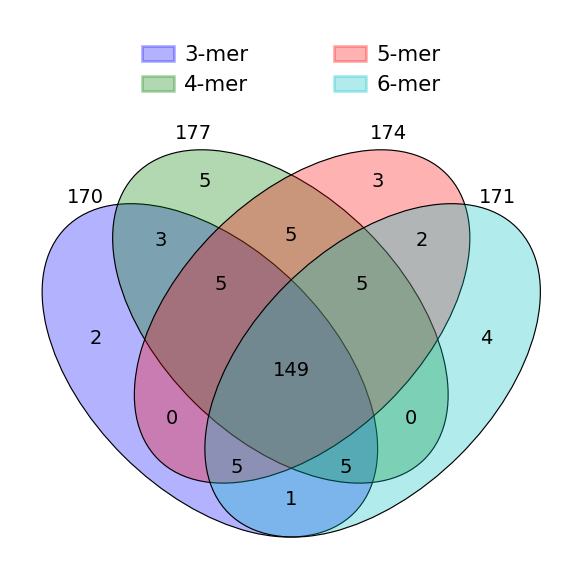

In [17]:
from venny4py.venny4py import *

venny4py(sets=correct_predictions_dict, out='analysis/venn/classifier')

# **Machine Learning Models**

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.ensemble import (
    AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier,
    RandomForestClassifier, StackingClassifier, VotingClassifier,
    ExtraTreesClassifier, HistGradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB, MultinomialNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.dummy import DummyClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import RFE, RFECV


from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [19]:
# List of meta-models
meta_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    # "Logistic Regression CV": LogisticRegressionCV(cv=5, max_iter=1000, random_state=42),
    "Multilayer Perceptron": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=1000, random_state=42),
    # "Extra Tree": ExtraTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Hist Gradient Boosting": HistGradientBoostingClassifier(max_iter=1000, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    # "Bagging Classifier": BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42),
    # "Voting Classifier": VotingClassifier(
    #     estimators=[
    #         ("rf", RandomForestClassifier(n_estimators=100, random_state=42)),
    #         ("svc", SVC(probability=True, random_state=42)),
    #         ("xgb", XGBClassifier(n_estimators=100, random_state=42)),
    #     ],
    #     voting="soft",
    # ),
    # "Stacking Classifier": StackingClassifier(
    #     estimators=[
    #         ("xgb", XGBClassifier(n_estimators=100, random_state=42)),
    #         ("lgbm", LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)),
    #         ("catboost", CatBoostClassifier(iterations=1000, random_state=42, verbose=0)),
    #     ],
    #     final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    # ),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
    "CatBoost": CatBoostClassifier(iterations=100, random_state=42, verbose=0),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "NuSVC": NuSVC(probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Radius Neighbors": RadiusNeighborsClassifier(radius=1.0),
    "Gaussian Process Classifier": GaussianProcessClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
    "SGD Classifier": SGDClassifier(loss="log_loss", max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Bernoulli Naive Bayes": BernoulliNB(),
    "Complement Naive Bayes": ComplementNB(),
    "Categorical Naive Bayes": CategoricalNB(),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Gaussian Mixture Model": GaussianMixture(n_components=2, random_state=42),
    "Bayesian Gaussian Mixture": BayesianGaussianMixture(n_components=2, random_state=42),
    "Label Propagation": LabelPropagation(),
    "Label Spreading": LabelSpreading(),
    # "Calibrated Classifier CV": CalibratedClassifierCV(estimator=RandomForestClassifier(n_estimators=100, random_state=42), cv=5),
    # "OneVsRest Classifier": OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000, random_state=42)),
    # "Pipeline": Pipeline(
    #     [
    #         ("scaler", StandardScaler()),
    #         ("classifier", LogisticRegression(max_iter=1000, random_state=42)),
    #     ]
    # ),
    # "RFE": RFE(
    #     estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    #     n_features_to_select=10,
    # ),
    # "RFECV": RFECV(
    #     estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    #     cv=5,
    #     scoring="accuracy",
    # ),
    "Dummy Classifier": DummyClassifier(strategy="most_frequent"),
}

In [20]:
# Prepare meta-features for training and testing
train_meta_features = np.column_stack(train_predictions_list)
test_meta_features = np.column_stack(test_predictions_list)

split_ratio = 0.9  # 90% training, 10% validation

In [21]:
# Dictionary to store results for each meta-model
train_stacking_results = {}
test_stacking_results = {}
threshold = 0.75

# Train meta-models on the entire training set
for model_name, meta_model in meta_models.items():
    # Train the meta-model on the entire training set
    meta_model.fit(train_meta_features, train_labels_list[0])

    # Meta-model predictions on the training set
    stacked_train_predictions = meta_model.predict_proba(train_meta_features)[:, 1]  # Probability for the positive class

    acc_train, sn_train, sp_train, mcc_train, auc_train = evaluate_metrics(stacked_train_predictions, train_labels_list[0], threshold=threshold)

    # Store training results
    train_stacking_results[model_name] = {"Accuracy": acc_train, "Sensitivity": sn_train, "Specificity": sp_train, "MCC": mcc_train, "AUC": auc_train}

    # Meta-model predictions on the independent (testing) set
    stacked_test_predictions = meta_model.predict_proba(test_meta_features)[:, 1]  # Probability for the positive class

    acc_test, sn_test, sp_test, mcc_test, auc_test = evaluate_metrics(stacked_test_predictions, test_labels_list[0], threshold=threshold)

    # Store testing results
    test_stacking_results[model_name] = {"Accuracy": acc_test, "Sensitivity": sn_test, "Specificity": sp_test, "MCC": mcc_test, "AUC": auc_test}

# Convert training results dictionary to list of lists for tabulate
train_stacking_table = []
for model_name, metrics in train_stacking_results.items():
    row = [model_name] + [f"{value:.4f}" for value in metrics.values()]
    train_stacking_table.append(row)

# Convert testing results dictionary to list of lists for tabulate
test_stacking_table = []
for model_name, metrics in test_stacking_results.items():
    row = [model_name] + [f"{value:.4f}" for value in metrics.values()]
    test_stacking_table.append(row)

# Sort the training table by accuracy, MCC, and AUC in descending order
train_stacking_table.sort(key=lambda x: (float(x[1]), float(x[4]), float(x[5])), reverse=True)

# Sort the testing table by accuracy, MCC, and AUC in descending order
test_stacking_table.sort(key=lambda x: (float(x[1]), float(x[4]), float(x[5])), reverse=True)

# Define table headers
headers = ["Meta-Model", "Accuracy", "Sensitivity", "Specificity", "MCC", "AUC"]

# Display training table
print("Stacking Training Results:")
print(tabulate(train_stacking_table, headers=headers, tablefmt="pretty"))

# Display testing table
print("Stacking Testing Results:")
print(tabulate(test_stacking_table, headers=headers, tablefmt="pretty"))


Stacking Training Results:
+---------------------------------+----------+-------------+-------------+--------+--------+
|           Meta-Model            | Accuracy | Sensitivity | Specificity |  MCC   |  AUC   |
+---------------------------------+----------+-------------+-------------+--------+--------+
|           Extra Trees           |  1.0000  |   1.0000    |   1.0000    | 1.0000 | 1.0000 |
|     Hist Gradient Boosting      |  1.0000  |   1.0000    |   1.0000    | 1.0000 | 1.0000 |
|            LightGBM             |  1.0000  |   1.0000    |   1.0000    | 1.0000 | 1.0000 |
|          Decision Tree          |  1.0000  |   1.0000    |   1.0000    | 1.0000 | 1.0000 |
|             XGBoost             |  0.9993  |   0.9987    |   1.0000    | 0.9987 | 1.0000 |
|          Random Forest          |  0.9737  |   0.9474    |   1.0000    | 0.9488 | 1.0000 |
|        Gradient Boosting        |  0.9690  |   0.9394    |   0.9987    | 0.9397 | 0.9922 |
|            CatBoost             |  0.9522

In [22]:
# Sort the testing table by accuracy in descending order and select top 10
top_10_test_stacking_table = sorted(test_stacking_table, key=lambda x: float(x[1]), reverse=True)[:10]

# Extract the model names of the top 10 based on testing accuracy
top_10_models = [row[0] for row in top_10_test_stacking_table]

# Create top 10 training table based on the top 10 models from testing
top_10_train_stacking_table = [row for row in train_stacking_table if row[0] in top_10_models]

# Ensure the order of the training table matches the testing table
top_10_train_stacking_table.sort(key=lambda x: top_10_models.index(x[0]))

# Define table headers
headers = ["Meta-Model", "Accuracy", "Sensitivity", "Specificity", "MCC", "AUC"]

# Display top 10 training table
print("Top 10 Stacking Training Results:")
print(tabulate(top_10_train_stacking_table, headers=headers, tablefmt="pretty"))

# Display top 10 testing table
print("Top 10 Stacking Testing Results:")
print(tabulate(top_10_test_stacking_table, headers=headers, tablefmt="pretty"))

Top 10 Stacking Training Results:
+------------------------------+----------+-------------+-------------+--------+--------+
|          Meta-Model          | Accuracy | Sensitivity | Specificity |  MCC   |  AUC   |
+------------------------------+----------+-------------+-------------+--------+--------+
|         Extra Trees          |  1.0000  |   1.0000    |   1.0000    | 1.0000 | 1.0000 |
|           XGBoost            |  0.9993  |   0.9987    |   1.0000    | 0.9987 | 1.0000 |
|           LightGBM           |  1.0000  |   1.0000    |   1.0000    | 1.0000 | 1.0000 |
|        Random Forest         |  0.9737  |   0.9474    |   1.0000    | 0.9488 | 1.0000 |
|    Hist Gradient Boosting    |  1.0000  |   1.0000    |   1.0000    | 1.0000 | 1.0000 |
|      Gradient Boosting       |  0.9690  |   0.9394    |   0.9987    | 0.9397 | 0.9922 |
|       Radius Neighbors       |  0.9252  |   0.8679    |   0.9825    | 0.8560 | 0.9518 |
| Linear Discriminant Analysis |  0.9259  |   0.8747    |   0.9771

In [23]:
model = ExtraTreesClassifier(n_estimators=1000, random_state=42)


threshold = 0.9999

# Train the Stacking Classifier on the training set
model.fit(train_meta_features , train_labels_list[0])

# Meta-model predictions on the validation set
train_predictions = model.predict_proba(train_meta_features )[:, 1]
test_predictions = model.predict_proba(test_meta_features)[:, 1]

# Evaluate metrics
train_labels = train_labels_list[0]
test_labels = test_labels_list[0]

train_acc, train_sn, train_sp, train_mcc, train_auc = evaluate_metrics(train_predictions, train_labels, threshold=threshold)
test_acc, test_sn, test_sp, test_mcc, test_auc = evaluate_metrics(test_predictions, test_labels, threshold=threshold)

# Display results in table using tabulate
results = [["Train", train_acc, train_sn, train_sp, train_mcc, train_auc], ["Test", test_acc, test_sn, test_sp, test_mcc, test_auc]]

headers = ["Dataset", "Accuracy", "Sensitivity", "Specificity", "MCC", "AUC"]

print(f"Threshold: {threshold}")
print(tabulate(results, headers=headers, tablefmt="grid", floatfmt=".4f"))

Threshold: 0.9999
+-----------+------------+---------------+---------------+--------+--------+
| Dataset   |   Accuracy |   Sensitivity |   Specificity |    MCC |    AUC |
+===========+============+===============+===============+========+========+
| Train     |     1.0000 |        1.0000 |        1.0000 | 1.0000 | 1.0000 |
+-----------+------------+---------------+---------------+--------+--------+
| Test      |     0.9900 |        1.0000 |        0.9800 | 0.9802 | 0.9900 |
+-----------+------------+---------------+---------------+--------+--------+
